In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from competition_library import *
from fastai.vision.all import *
from collections import Counter
import matplotlib.pyplot as plt
from timm import *
import gc

In [2]:
torch.cuda.is_available()

True

In [3]:
prob_keep = 1
bs=64//2
num_epoch = 10
num_epoch_freeze= 1
img_size = 1024//2
arch =['convnext_small_in22k','resnet50'][0] 
path_dict = {"1024":{"train_path":'/home/remi/Documents/kaggle_data/train_images_1024/',
                    "test_path":'/home/remi/Documents/kaggle_data/test_images_1024/' },
            "512":{"train_path":'/home/remi/Documents/kaggle_data/train_images_512/',
                    "test_path":'/home/remi/Documents/kaggle_data/test_images_512/' },
            "256":{"train_path":'/home/remi/Documents/kaggle_data/train_images_256/',
                    "test_path":'/home/remi/Documents/kaggle_data/test_images_256/'},
            }
path_dict = path_dict[str(img_size)] 

lr_find = False
assemble = True

In [4]:
path_dict

{'train_path': '/home/remi/Documents/kaggle_data/train_images_512/',
 'test_path': '/home/remi/Documents/kaggle_data/test_images_512/'}

In [5]:
#code to resize images

#path = '/home/remi/Documents/kaggle_data/test_1024/'
#p_512 = '/home/remi/Documents/kaggle_data/test_512/'
#resize_images(path, dest=p_512, max_size=512, recurse=True)
#
#path = p_512

In [6]:
files = get_image_files(path_dict["train_path"] )
split_file = randomly_subsample(files,prob_keep=prob_keep)

In [7]:
#get label for each image.
f = open("/home/remi/Documents/kaggle_data/train_cultivar_mapping.csv","r")
f.readline()
image_to_category = {}
list_label =[] 
for i in f.readlines():
    split = i.split(",")
    image_to_category[split[0]]= split[1].replace("\n", "")
    list_label.append(split[1] )
    # if split[1].replace("\n", "") == "PI_92270" :
    # #  print(path + split[0])
    #     shutil.copy(path + split[0], "/home/remi/Desktop/PI_92270/")
    #print(i.split(","))
f.close()

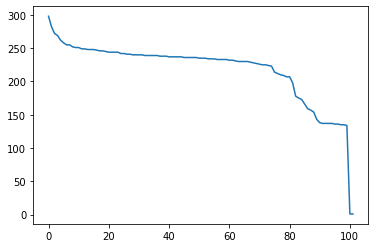

In [8]:
# Let's have a look to distribution 
l = list(Counter(list_label).values())
l.sort(reverse=True )
plt.plot( l )

In [9]:
def label_func(path_obj):
    return image_to_category[os.path.basename(path_obj)]

In [10]:
# default aug
aug = aug_transforms(mult=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip=True, # Random flipping
    flip_vert=False, # Flip vertically
    max_rotate=10., # Maximum degree of rotation
    min_zoom=1., # Minimum zoom 
    max_zoom=1.1, # Maximum zoom 
    max_lighting=0.2, # Maximum scale of changing brightness 
    max_warp=0.2, # Maximum value of changing warp per
    p_affine=0.75, # Probability of applying affine transformation
    p_lighting=0.75, # Probability of changing brightnest and contrast 
    xtra_tfms=None, # Custom Transformations
    size=None, # Output size, duplicated if one value is specified
    mode='bilinear', # PyTorch `F.grid_sample` interpolation
    pad_mode=PadMode.Reflection, # A `PadMode`
    align_corners=True, # PyTorch `F.grid_sample` align_corners
    batch=False, # Apply identical transformation to entire batch
    min_scale=1.) # Minimum scale of the crop, in relation to image area)

In [11]:
aug = aug_transforms(
    mult=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip=True, # Random flipping
    flip_vert=True, # Flip vertically
    max_rotate=20., # Maximum degree of rotation
    min_zoom=0.9, # Minimum zoom 
    max_zoom=1.2, # Maximum zoom 
    max_lighting=0.3, # Maximum scale of changing brightness 
    max_warp=0.2, # Maximum value of changing warp per
    p_affine=0.75, # Probability of applying affine transformation
    p_lighting=0.75, # Probability of changing brightnest and contrast 
    xtra_tfms=None, # Custom Transformations
    size=None, # Output size, duplicated if one value is specified
    mode='bilinear', # PyTorch `F.grid_sample` interpolation
    pad_mode=PadMode.Reflection, # A `PadMode`
    align_corners=True, # PyTorch `F.grid_sample` align_corners
    batch=False, # Apply identical transformation to entire batch
    min_scale=1.) # Minimum scale of the crop, in relation to image area)

In [12]:
if not assemble:
    dls = ImageDataLoaders.from_name_func(path_dict["train_path"], split_file, label_func, item_tfms=Resize(img_size),bs=bs,batch_tfms=aug, seed=42, valid_pct=0.2)

In [13]:
if not assemble:
    dls.show_batch(unique=True)

In [14]:
if not assemble:
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()

    if lr_find:
        learn.lr_find(suggest_funcs=(valley, slide))

    #default aug
    #14	2.132918	3.053929	0.719457	00:41

In [15]:
if not assemble:
    learn.fine_tune(epochs=num_epoch,
        base_lr=0.002,
        freeze_epochs=num_epoch_freeze)
    # learn.fit_one_cycle(1)

In [16]:
# Need it in both cases
tst_files = get_image_files(path_dict["test_path"]).sorted()

if not assemble:
    tst_dl = dls.test_dl(tst_files)
    probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [17]:
if not assemble:
    list_df =[] 
    list_cultivar =[] 

    for i in tqdm(range(len(tst_files))):
        list_df.append(os.path.basename(tst_files[i]))
        list_cultivar.append(dls.vocab[idxs[i]])

    import pandas as pd
    d = {'filename': list_df, 'cultivar': list_cultivar}
    df = pd.DataFrame(d)
    print(df)
    df.to_csv('submissionRemi_noTTA.csv', index=False)


In [18]:
if not assemble: 
    #run TTA 
    tta_res = learn.tta(dl=dls.test_dl(tst_files))
    tta_res[0].shape

In [19]:
if not assemble:
    idxs = [x.item() for x in tta_res[0].argmax(1)] 
    list_df =[] 
    list_cultivar =[] 

    for i in tqdm(range(len(tst_files))):#    len(tst_files)):
        list_df.append(os.path.basename(tst_files[i]))
        list_cultivar.append(dls.vocab[idxs[i]])

    d = {'filename': list_df, 'cultivar': list_cultivar}
    df = pd.DataFrame(d)
    # print(df)
    fn = f'submissionRemi_TTA_res18_256_.csv'
    df.to_csv(fn, index=False)

# Assembling

In this section we will perfome assembling, training our models on different train/val split

In [20]:
if assemble:
    def train(arch, size, accum=1,  epochs=12):
        item=Resize(size, method='squish')
        dls = ImageDataLoaders.from_name_func(path_dict["test_path"], split_file, label_func, item_tfms=item, bs=32//accum, batch_tfms=aug, valid_pct=0.2)
        cbs = GradientAccumulation(64) if accum else []
        learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
        #learn.fit_one_cycle(epochs)#
        learn.fine_tune(epochs, 0.01)

        return learn.tta(dl=dls.test_dl(get_image_files(path_dict["test_path"]).sorted()))

In [21]:
if assemble:
    gc.collect()
    torch.cuda.empty_cache()

In [22]:
if assemble:
   #num epoch to train 
    epoch = 45
    models = {
    'convnext_large_in22k':{"size": img_size, "epochs":epoch, "accum":8},
    #'resnet50':{"size": 512, "epochs":epoch, "accum":4},
    # 'resnet50':{"size": 1024, "epochs":epoch, "accum":11}
    'convnext_large':{"size": img_size, "epochs":epoch, "accum":8},

    } 

In [23]:
if assemble:
   #train and run inference on test_set 
    tta_res = []
    for arch,dict_arch in models.items():
        print('---',arch)
        tta_res.append(train(arch, dict_arch["size"], epochs=dict_arch["epochs"], accum=dict_arch["accum"]))
        #clean GPU memory between 2 runs 
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k


epoch,train_loss,valid_loss,error_rate,time
0,3.382900,2.513662,0.652546,1:00:36


epoch,train_loss,valid_loss,error_rate,time
0,2.078592,1.150287,0.295854,1:16:20
1,1.660528,0.814216,0.217215,1:09:32
2,1.395239,0.577965,0.155025,1:08:09
3,1.247813,0.479253,0.133844,1:10:07
4,1.066889,0.394651,0.119874,1:08:52
5,1.018420,0.324208,0.093060,1:08:50
6,0.895718,0.328647,0.100270,1:08:50
7,1.295174,0.393099,0.120775,1:08:53
8,0.873674,0.212757,0.070527,1:08:45
9,0.720369,0.238718,0.076836,1:08:45


--- convnext_large


epoch,train_loss,valid_loss,error_rate,time
0,3.985507,2.936361,0.734114,1:00:14


epoch,train_loss,valid_loss,error_rate,time
0,3.046580,1.903440,0.467553,1:16:10
1,2.281073,1.403576,0.333484,1:16:39
2,2.246383,1.074196,0.276701,1:16:22
3,1.803804,0.865746,0.213835,1:16:25
4,1.676632,0.722976,0.188598,1:16:19
5,1.369834,0.661040,0.186796,1:16:24
6,1.409817,0.503475,0.139928,1:16:39
7,1.112336,0.448275,0.131591,1:16:16
8,1.063538,0.391413,0.108833,1:16:23
9,1.042730,0.337160,0.097341,1:16:39


In [24]:
if assemble: 
    save_pickle(f'tta_res_imgSize{img_size}_probkeep{prob_keep}_.pkl', tta_res)


In [25]:
if assemble: 
    # convert tensor of prob to argument 
    tta_res[-1][0].argmax(1).shape
    dls = ImageDataLoaders.from_name_func(path_dict["train_path"], split_file, label_func, batch_tfms=aug, valid_pct=0.2)

    names = list(models.keys())
    names.append("assemble")
    print(names)


['convnext_large_in22k', 'convnext_large', 'assemble']


In [26]:
if assemble:
    tta_res2 = tta_res.copy()
    for model_idx in range(len(names)):
        if model_idx < len(names)-1:
           #regular model 
            idxs = [x.item() for x in list(tta_res[model_idx][0].argmax(1))] 
        else:
           #for this one we perform assembling 
            idxs = [x.item() for x in torch.stack([x[0] for x in  tta_res2],2).mean(-1).argmax(1)] 
            
        list_df =[] 
        list_cultivar =[] 
        # we save our predictions to a csv file.
        for i in tqdm(range(len(tst_files))):
            list_df.append(os.path.basename(tst_files[i]))
            list_cultivar.append(dls.vocab[idxs[i]])

        d = {'filename': list_df, 'cultivar': list_cultivar}
        df = pd.DataFrame(d)
       # print(df)
        fn = f'submissionRemi_TTA_{names[model_idx]}_.csv'
        print(fn)
        df.to_csv(fn, index=False)

  0%|          | 0/23639 [00:00<?, ?it/s]

submissionRemi_TTA_convnext_large_in22k_.csv


  0%|          | 0/23639 [00:00<?, ?it/s]

submissionRemi_TTA_convnext_large_.csv


100%|██████████| 23639/23639 [00:00<00:00, 23666.03it/s]


submissionRemi_TTA_assemble_.csv
